## Setup Environment

In [284]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import fiona

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

# Data Preprocessing 

### I. County Shapefile

In [2]:
county = gpd.read_file("UScounties/UScounties.shp")

In [3]:
county.head(2)

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry
0,Lake of the Woods,Minnesota,27,077,27077,"POLYGON ((-95.34283 48.54668, -95.34105 48.715..."
1,Ferry,Washington,53,019,53019,"POLYGON ((-118.85163 47.94956, -118.84846 48.4..."


In [4]:
county['NAME'] = county['NAME'] + ' County'

### II. County Business Data (CBP) 

In [5]:
# Read the TXT file into a DataFrame
df_12 = pd.read_csv('CBP/cbp12co.txt', delimiter=',')
df_20 = pd.read_csv('CBP/cbp20co.txt', delimiter=',')

In [6]:
print(len(df_12))
df_12.head(2)

2131529


,fipstate,fipscty,naics,empflag,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,...,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4,censtate,cencty
0,1,1,------,NaN,G,9908,G,65428,G,280188,...,7,1,1,0,0,0,0,0,63,1
1,1,1,11----,NaN,H,30,H,264,G,1102,...,0,0,0,0,0,0,0,0,63,1


In [7]:
print(len(df_20))
df_20.head(2)

1082434


,fipstate,fipscty,naics,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,est,...,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4
0,1,1,------,G,11265,G,94865,G,385785,879,...,104,32,9,N,N,N,N,N,N,N
1,1,1,11----,H,92,G,1183,H,5232,10,...,N,N,N,N,N,N,N,N,N,N


In [8]:
df_12.columns

Index(['fipstate', 'fipscty', 'naics', 'empflag', 'emp_nf', 'emp', 'qp1_nf',
       'qp1', 'ap_nf', 'ap', 'est', 'n1_4', 'n5_9', 'n10_19', 'n20_49',
       'n50_99', 'n100_249', 'n250_499', 'n500_999', 'n1000', 'n1000_1',
       'n1000_2', 'n1000_3', 'n1000_4', 'censtate', 'cencty'],
      dtype='object')

In [9]:
df_20.columns

Index(['fipstate', 'fipscty', 'naics', 'emp_nf', 'emp', 'qp1_nf', 'qp1',
       'ap_nf', 'ap', 'est', 'n<5', 'n5_9', 'n10_19', 'n20_49', 'n50_99',
       'n100_249', 'n250_499', 'n500_999', 'n1000', 'n1000_1', 'n1000_2',
       'n1000_3', 'n1000_4'],
      dtype='object')

In [10]:
# 2012 Data
# define a custom function to process each element
df_12 = df_12.replace('N', 0)

# convert data type
df_12['n1_4'] = df_12['n1_4'].astype(int)
df_12['n5_9'] = df_12['n5_9'].astype(int)
df_12['n10_19'] = df_12['n10_19'].astype(int)
df_12['n20_49'] = df_12['n20_49'].astype(int)
df_12['n50_99'] = df_12['n50_99'].astype(int)
df_12['n100_249'] = df_12['n100_249'].astype(int)
df_12['n250_499'] = df_12['n250_499'].astype(int)
df_12['n500_999'] = df_12['n500_999'].astype(int)
df_12['n1000_1'] = df_12['n1000_1'].astype(int)
df_12['n1000_2'] = df_12['n1000_2'].astype(int)
df_12['n1000_3'] = df_12['n1000_3'].astype(int)
df_12['n1000_4'] = df_12['n1000_4'].astype(int)

# Rescaling 
df_12["1000less"] = df_12['n1_4'] + df_12['n5_9'] + df_12['n10_19'] + df_12['n20_49'] + df_12['n50_99'] + df_12['n100_249'] + df_12['n250_499'] + df_12['n500_999']
df_12["1000to5000"] = df_12['n1000_1'] + df_12['n1000_2'] + df_12['n1000_3']
df_12["5000more"] = df_12["n1000_4"]

df_12.loc[:,"naics"] = df_12.loc[:,"naics"].str[:2]

#2020 Data
# define a custom function to process each element
df_20 = df_20.replace('N', 0)

# convert data type
df_20['n<5'] = df_20['n<5'].astype(int)
df_20['n5_9'] = df_20['n5_9'].astype(int)
df_20['n10_19'] = df_20['n10_19'].astype(int)
df_20['n20_49'] = df_20['n20_49'].astype(int)
df_20['n50_99'] = df_20['n50_99'].astype(int)
df_20['n100_249'] = df_20['n100_249'].astype(int)
df_20['n250_499'] = df_20['n250_499'].astype(int)
df_20['n500_999'] = df_20['n500_999'].astype(int)
df_20['n1000_1'] = df_20['n1000_1'].astype(int)
df_20['n1000_2'] = df_20['n1000_2'].astype(int)
df_20['n1000_3'] = df_20['n1000_3'].astype(int)
df_20['n1000_4'] = df_20['n1000_4'].astype(int)

# Rescaling 
df_20["1000less"] = df_20['n<5'] + df_20['n5_9'] + df_20['n10_19'] + df_20['n20_49'] + df_20['n50_99'] + df_20['n100_249'] + df_12['n250_499'] + df_12['n500_999']
df_20["1000to5000"] = df_20['n1000_1'] + df_20['n1000_2'] + df_20['n1000_3']
df_20["5000more"] = df_20["n1000_4"]

df_20.loc[:,"naics"] = df_20.loc[:,"naics"].str[:2]


In [11]:
CBP_12 = df_12[["fipstate","fipscty", "naics", "emp", "est", "1000less","1000to5000","5000more"]]
CBP_20 = df_20[["fipstate","fipscty", "naics", "emp", "est", "1000less","1000to5000","5000more"]]

In [12]:
# create a dictionary with the category names and corresponding 2-digit NAICS codes
naics_dict = {"Agriculture, forestry, fishing, and hunting": ["11"],
              "Mining": ["21"],
              "Utilities": ["22"],
              "Construction": ["23"],
              "Manufacturing": ["31", "32", "33"],
              "Wholesale trade": ["42"],
              "Retail trade": ["44", "45"],
              "Transportation and warehousing": ["48", "49"],
              "Information": ["51"],
              "Finance and insurance": ["52"],
              "Real estate and rental and leasing": ["53"],
              "Professional, scientific, and technical services": ["54"],
              "Management of companies and enterprises": ["55"],
              "Administrative and support and waste management and remediation services": ["56"],
              "Educational services": ["61"],
              "Health care and social assistance": ["62"],
              "Arts, entertainment, and recreation": ["71"],
              "Accommodation and food services": ["72"],
              "Other services (except public administration)": ["81"],
              "Public administration": ["92"]}

# map the category names to the naics column
CBP_12["category"] = CBP_12["naics"].map({naics_code: category_name for category_name, naics_codes in naics_dict.items() for naics_code in naics_codes})
CBP_20["category"] = CBP_20["naics"].map({naics_code: category_name for category_name, naics_codes in naics_dict.items() for naics_code in naics_codes})


# filter out empty categories
CBP_12 = CBP_12[CBP_12["category"].notnull()]
CBP_20 = CBP_20[CBP_20["category"].notnull()]


/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/3308171288.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CBP_12["category"] = CBP_12["naics"].map({naics_code: category_name for category_name, naics_codes in naics_dict.items() for naics_code in naics_codes})
/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/3308171288.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CBP_20["category"] = CBP_20["naics"].map({naics_code: category_name for category_name, naics_codes in

In [13]:
# 2012 Data
# add leading zeros to 'fipstate' and 'fipscty' columns
CBP_12['fipstate'] = CBP_12['fipstate'].apply(lambda x: '{0:0>2}'.format(x))
CBP_12['fipscty'] = CBP_12['fipscty'].apply(lambda x: '{0:0>3}'.format(x))

# combine 'fipstate' and 'fipscty' columns into a new 'fips' column
CBP_12['fips'] = CBP_12['fipstate'] + CBP_12['fipscty']

# drop 'fipstate' and 'fipscty' columns
CBP_12.drop(['fipstate', 'fipscty'], axis=1, inplace=True)

#2020 Data
# add leading zeros to 'fipstate' and 'fipscty' columns
CBP_20['fipstate'] = CBP_20['fipstate'].apply(lambda x: '{0:0>2}'.format(x))
CBP_20['fipscty'] = CBP_20['fipscty'].apply(lambda x: '{0:0>3}'.format(x))

# combine 'fipstate' and 'fipscty' columns into a new 'fips' column
CBP_20['fips'] = CBP_20['fipstate'] + CBP_20['fipscty']

# drop 'fipstate' and 'fipscty' columns
CBP_20.drop(['fipstate', 'fipscty'], axis=1, inplace=True)

/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/2129421767.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CBP_12['fipstate'] = CBP_12['fipstate'].apply(lambda x: '{0:0>2}'.format(x))
/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/2129421767.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  CBP_12['fipscty'] = CBP_12['fipscty'].apply(lambda x: '{0:0>3}'.format(x))
/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/2129421767.py:7: SettingWithCopyWarning

In [14]:
#CBP_12_Grouped = CBP_12.groupby(['fips', 'category'], as_index=False).sum().reindex()
CBP_12_Grouped = CBP_12.groupby(['fips'], as_index=False).sum().reindex()
CBP_12_Grouped = CBP_12_Grouped.drop_duplicates()

#CBP_20_Grouped = CBP_20.groupby(['fips', 'category'], as_index=False).sum().reindex()
CBP_20_Grouped = CBP_20.groupby(['fips'], as_index=False).sum().reindex()
CBP_20_Grouped = CBP_20_Grouped.drop_duplicates()

/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/4113668537.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  CBP_12_Grouped = CBP_12.groupby(['fips'], as_index=False).sum().reindex()
/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/4113668537.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  CBP_20_Grouped = CBP_20.groupby(['fips'], as_index=False).sum().reindex()


In [15]:
FDI_df_12 = pd.merge(county[['FIPS','NAME', 'STATE_NAME']], 
                 CBP_12_Grouped[['fips','1000less', '1000to5000','5000more']], 
                 left_on='FIPS', right_on='fips', how = 'inner')

FDI_df_12.drop(['FIPS','fips'], axis=1, inplace=True)

FDI_df_20 = pd.merge(county[['FIPS','NAME', 'STATE_NAME']], 
                 CBP_12_Grouped[['fips','1000less', '1000to5000','5000more']], 
                 left_on='FIPS', right_on='fips', how = 'inner')

FDI_df_20.drop(['FIPS','fips'], axis=1, inplace=True)

In [16]:
FDI_df_12.head(2)

,NAME,STATE_NAME,1000less,1000to5000,5000more
0,Lake of the Woods County,Minnesota,790,0,0
1,Ferry County,Washington,675,0,0


In [17]:
FDI_df_20.head(2)

,NAME,STATE_NAME,1000less,1000to5000,5000more
0,Lake of the Woods County,Minnesota,790,0,0
1,Ferry County,Washington,675,0,0


### III. Quarterly Census of Employment and Wages  (QCEW)

In [18]:
QCEW_12 = pd.read_csv('QCEW/allhlcn12.csv')
QCEW_20 = pd.read_csv('QCEW/allhlcn20.csv')

/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/2790758331.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  QCEW_12 = pd.read_csv('QCEW/allhlcn12.csv')
/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/2790758331.py:2: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  QCEW_20 = pd.read_csv('QCEW/allhlcn20.csv')


In [19]:
print(len(QCEW_12))
QCEW_12.head(2)

62555


,Area\nCode,St,Cnty,Own,NAICS,Year,Qtr,Area Type,St Name,Area,Ownership,Industry,Annual Average Status Code,Annual Average Establishment Count,Annual Average Employment,Annual Total Wages,Annual Average Weekly Wage,Annual Average Pay,Employment Location Quotient Relative to U.S.,Total Wage Location Quotient Relative to U.S.
0,US000,US,0.0,0,10,2012,A,Nation,NaN,U.S. TOTAL,Total Covered,"Total, all industries",NaN,"9,121,868","131,696,378","6,491,224,497,893",948,"49,289",1.0,1.0
1,US000,US,0.0,1,10,2012,A,Nation,NaN,U.S. TOTAL,Federal Government,"Total, all industries",NaN,"65,076","2,820,722","206,871,277,590","1,410","73,340",1.0,1.0


In [20]:
print(len(QCEW_20))
QCEW_20.head(2)

62892


,Area\nCode,St,Cnty,Own,NAICS,Year,Qtr,Area Type,St Name,Area,Ownership,Industry,Annual Average Status Code,Annual Average Establishment Count,Annual Average Employment,Annual Total Wages,Annual Average Weekly Wage,Annual Average Pay,Employment Location Quotient Relative to U.S.,Total Wage Location Quotient Relative to U.S.
0,US000,US,0.0,0,10,2020,A,Nation,NaN,U.S. TOTAL,Total Covered,"10 Total, all industries",NaN,"10,487,687","139,103,773","8,905,606,771,748","1,231","64,021",1.0,1.0
1,US000,US,0.0,1,10,2020,A,Nation,NaN,U.S. TOTAL,Federal Government,"10 Total, all industries",NaN,"61,310","2,928,036","250,251,253,418","1,644","85,467",1.0,1.0


In [21]:
QCEW_12 = QCEW_12[QCEW_12["Area Type"] == "County"]
QCEW_12 = QCEW_12[QCEW_12["Industry"] == "Total, all industries"]
QCEW_12[['county', 'state']] = QCEW_12['Area'].str.split(', ', expand=True)

QCEW_12 = QCEW_12[['county', 'state','Annual Average Establishment Count',
                   'Annual Average Employment', 'Annual Total Wages', 'Annual Average Pay']]

QCEW_20 = QCEW_20[QCEW_20["Area Type"] == "County"]
QCEW_20 = QCEW_20[QCEW_20["Industry"] == "10 Total, all industries"]
QCEW_20[['county', 'state']] = QCEW_20['Area'].str.split(', ', expand=True)

QCEW_20 = QCEW_20[['county', 'state', 'Annual Average Establishment Count',
                   'Annual Average Employment', 'Annual Total Wages', 'Annual Average Pay']]

In [22]:
QCEW_12['Annual Average Establishment Count'] = QCEW_12['Annual Average Establishment Count'].str.replace(',', '').astype(int)
QCEW_12['Annual Average Employment'] = QCEW_12['Annual Average Employment'].str.replace(',', '').astype(int)
QCEW_12['Annual Total Wages'] = QCEW_12['Annual Total Wages'].str.replace(',', '').astype(int)
QCEW_12['Annual Average Pay'] = QCEW_12['Annual Average Pay'].str.replace(',', '').astype(int)

QCEW_20['Annual Average Establishment Count'] = QCEW_20['Annual Average Establishment Count'].str.replace(',', '').astype(int)
QCEW_20['Annual Average Employment'] = QCEW_20['Annual Average Employment'].str.replace(',', '').astype(int)
QCEW_20['Annual Total Wages'] = QCEW_20['Annual Total Wages'].str.replace(',', '').astype(int)
QCEW_20['Annual Average Pay'] = QCEW_20['Annual Average Pay'].str.replace(',', '').astype(int)

In [23]:
QCEW_12_Grouped = QCEW_12.groupby(['county', 'state'], as_index=False).sum().reindex()
QCEW_12_Grouped = QCEW_12_Grouped.drop_duplicates()
QCEW_20_Grouped = QCEW_20.groupby(['county', 'state'], as_index=False).sum().reindex()
QCEW_20_Grouped = QCEW_20_Grouped.drop_duplicates()

In [24]:
FDI_df_12_1 = pd.merge(QCEW_12_Grouped, FDI_df_12,
                 left_on=['county', 'state'], right_on=['NAME','STATE_NAME'], how = 'inner')

FDI_df_12_1.drop(['NAME','STATE_NAME'], axis=1, inplace=True)

FDI_df_20_1 = pd.merge(QCEW_20_Grouped, FDI_df_20,
                 left_on=['county', 'state'], right_on=['NAME','STATE_NAME'], how = 'inner')

FDI_df_20_1.drop(['NAME','STATE_NAME'], axis=1, inplace=True)

In [25]:
FDI_df_12_1.head(2)

,county,state,Annual Average Establishment Count,Annual Average Employment,Annual Total Wages,Annual Average Pay,1000less,1000to5000,5000more
0,Abbeville County,South Carolina,700,11053,340296068,175341,1685,0,0
1,Accomack County,Virginia,1898,25307,827518166,209313,3860,10,0


In [26]:
FDI_df_20_1.head(2)

,county,state,Annual Average Establishment Count,Annual Average Employment,Annual Total Wages,Annual Average Pay,1000less,1000to5000,5000more
0,Abbeville County,South Carolina,724,10629,434850330,212513,1685,0,0
1,Accomack County,Virginia,2148,24288,1076422962,256564,3860,10,0


### IV. County Population

In [27]:
Population = pd.read_csv("Population/co-est2020-alldata.csv", encoding='latin-1')

In [28]:
print(len(Population))
Population.head(2)

3194


,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019,RNETMIG2020
0,40,3,6,1,0,Alabama,Alabama,4779736,4780118,4785514,...,0.680010,1.282825,1.614391,0.653828,0.730419,0.854384,1.197150,1.966095,2.677866,3.091308
1,50,3,6,1,1,Alabama,Autauga County,54571,54582,54761,...,6.236931,-5.971016,-3.773344,2.206640,-1.529706,4.954403,0.993228,-0.018021,3.486011,6.290545


In [175]:
Population_12 = Population[["STNAME", "CTYNAME", "POPESTIMATE2012", "RDOMESTICMIG2012", "RINTERNATIONALMIG2012", "RNATURALINC2012"]]
Population_20 = Population[["STNAME", "CTYNAME", "POPESTIMATE2020", "RDOMESTICMIG2020", "RINTERNATIONALMIG2020", "RNATURALINC2020"]]

In [176]:
Population_12.head(2)

,STNAME,CTYNAME,POPESTIMATE2012,RDOMESTICMIG2012,RINTERNATIONALMIG2012,RNATURALINC2012
0,Alabama,Alabama,4816632,-0.023710,1.306535,2.227682
1,Alabama,Autauga County,54970,-5.971016,0.000000,0.998194


In [177]:
Population_20.head(2)

,STNAME,CTYNAME,POPESTIMATE2020,RDOMESTICMIG2020,RINTERNATIONALMIG2020,RNATURALINC2020
0,Alabama,Alabama,4921532,2.668499,0.422809,-0.328603
1,Alabama,Autauga County,56145,6.433511,-0.142967,0.428901


In [178]:
FDI_df_12_2 = pd.merge(FDI_df_12_1, Population_12,
                 left_on=['county', 'state'], right_on=['CTYNAME','STNAME'], how = 'inner')

FDI_df_12_2.drop(['CTYNAME','STNAME'], axis=1, inplace=True)

FDI_df_20_2 = pd.merge(FDI_df_20_1,Population_20, 
                 left_on=['county', 'state'], right_on=['CTYNAME','STNAME'], how = 'inner')

FDI_df_20_2.drop(['CTYNAME','STNAME'], axis=1, inplace=True)

In [179]:
FDI_df_12_2.head(2)

,county,state,Annual Average Establishment Count,Annual Average Employment,Annual Total Wages,Annual Average Pay,1000less,1000to5000,5000more,POPESTIMATE2012,RDOMESTICMIG2012,RINTERNATIONALMIG2012,RNATURALINC2012
0,Abbeville County,South Carolina,700,11053,340296068,175341,1685,0,0,25033,-4.229342,0.758090,1.157084
1,Accomack County,Virginia,1898,25307,827518166,209313,3860,10,0,33276,-1.804430,2.556276,0.992436


In [180]:
FDI_df_20_2.head(2)

,county,state,Annual Average Establishment Count,Annual Average Employment,Annual Total Wages,Annual Average Pay,1000less,1000to5000,5000more,POPESTIMATE2020,RDOMESTICMIG2020,RINTERNATIONALMIG2020,RNATURALINC2020
0,Abbeville County,South Carolina,724,10629,434850330,212513,1685,0,0,24404,-4.041806,0.00000,-3.266106
1,Accomack County,Virginia,2148,24288,1076422962,256564,3860,10,0,32238,0.000000,1.61083,-4.305872


### V. Foreign Direct Investment (FDI)

In [181]:
FDI_12 = pd.read_csv("FDI/FDI_2012.csv")

In [182]:
print(len(FDI_12))
FDI_12.head(2)

705


,County Name,Percent foreign employment,Wage ratio
0,"Baldwin County, Alabama",1.4%,1.68
1,"Calhoun County, Alabama",4.0%,1.18


In [183]:
print(type(FDI_12['Percent foreign employment'][0]))
print(type(FDI_12['Wage ratio'][0]))

<class 'str'>
<class 'numpy.float64'>


In [184]:
# define a function to convert a percentage string to a numerical value
def percentage_to_numeric(percentage_string):
    percentage = float(percentage_string.rstrip('%'))
    return round(percentage / 100, 2)

# apply the function to the 'percentages' column and create a new column 'numeric_values'
FDI_12['Percent foreign employment'] = FDI_12['Percent foreign employment'].apply(percentage_to_numeric)

In [185]:
FDI_12['Percent foreign employment'].describe()

count    705.000000
mean       0.051348
std        0.036789
min        0.010000
25%        0.030000
50%        0.040000
75%        0.060000
max        0.400000
Name: Percent foreign employment, dtype: float64

In [186]:
FDI_12['Wage ratio'].describe()

count    705.000000
mean       1.383206
std        0.338490
min        0.580000
25%        1.160000
50%        1.340000
75%        1.570000
max        3.300000
Name: Wage ratio, dtype: float64

In [187]:
FDI_12[['county', 'state']] = FDI_12['County Name'].str.split(', ', expand=True)

In [189]:
# assign FDI label by metrics 
FDI_12.loc[(FDI_12['Percent foreign employment'] > 0.1) | (FDI_12['Wage ratio'] > 2), 'FDI'] = 1
FDI_12['FDI'].fillna(0 , inplace=True)

In [190]:
FDI_12['FDI'].describe()

count    705.000000
mean       0.095035
std        0.293472
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: FDI, dtype: float64

In [191]:
FDI_Label = FDI_12[['county', 'state','FDI']]

In [193]:
FDI_Labeled = pd.merge(FDI_df_12_2, FDI_Label,
                 left_on=['county', 'state'], right_on=['county', 'state'], how = 'inner')

In [195]:
FDI_Labeled.columns

Index(['county', 'state', 'Annual Average Establishment Count',
       'Annual Average Employment', 'Annual Total Wages', 'Annual Average Pay',
       '1000less', '1000to5000', '5000more', 'POPESTIMATE2012',
       'RDOMESTICMIG2012', 'RINTERNATIONALMIG2012', 'RNATURALINC2012', 'FDI'],
      dtype='object')

# Classificaiton 

### Train a decision tree model to distinguish 2020 High FDI county based on 2012 BEA report 

In [196]:
# select the relevant features and target variable
X = FDI_Labeled[['Annual Average Establishment Count',
       'Annual Average Employment', 'Annual Total Wages', 'Annual Average Pay',
       '1000less', '1000to5000', '5000more', 'POPESTIMATE2012',
       'RDOMESTICMIG2012', 'RINTERNATIONALMIG2012', 'RNATURALINC2012']]
y = FDI_Labeled['FDI']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# create a logistic regression model
model1 = LogisticRegression()

# create a decision tree classifier
model2 = DecisionTreeClassifier(random_state=42)
# define the hyperparameter grid to search over
param_grid = {'max_depth': [3, 5, 7, 10, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2', None]}
# perform a grid search over the hyperparameter grid using cross-validation
grid_search = GridSearchCV(model2, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
# retrieve the best model and make predictions on the testing set
model2 = grid_search.best_estimator_


# create a Random Forest classifier
model3 = RandomForestClassifier(n_estimators=100)
# define the hyperparameter grid to search over
param_grid = {'max_depth': [3, 5, 7, 10, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2', None]}
# perform a grid search over the hyperparameter grid using cross-validation
grid_search = GridSearchCV(model3, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
# retrieve the best model and make predictions on the testing set
model3 = grid_search.best_estimator_

# create a KNN classifier
model4 = KNeighborsClassifier(n_neighbors=10)
# define the hyperparameter grid to search over
param_grid = {'n_neighbors': [3, 5, 7, 10, 15],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}

# perform a grid search over the hyperparameter grid using cross-validation
grid_search = GridSearchCV(model4, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# retrieve the best model and make predictions on the testing set
model4 = grid_search.best_estimator_

# train the model on the training set
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
model4.fit(X_train, y_train)

# make predictions on the testing set
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)
y_pred4 = model4.predict(X_test)

# evaluate the model's accuracy
accuracy1 = accuracy_score(y_test, y_pred1)
print('Logistic Accuracy:', accuracy1)
accuracy2 = accuracy_score(y_test, y_pred2)
print('Decision Tree Accuracy:', accuracy2)
accuracy3 = accuracy_score(y_test, y_pred3)
print('Random Forest Accuracy:', accuracy3)
accuracy4 = accuracy_score(y_test, y_pred4)
print('KNN Accuracy:', accuracy4)

Logistic Accuracy: 0.9166666666666666
Decision Tree Accuracy: 0.8712121212121212
Random Forest Accuracy: 0.9166666666666666
KNN Accuracy: 0.9090909090909091


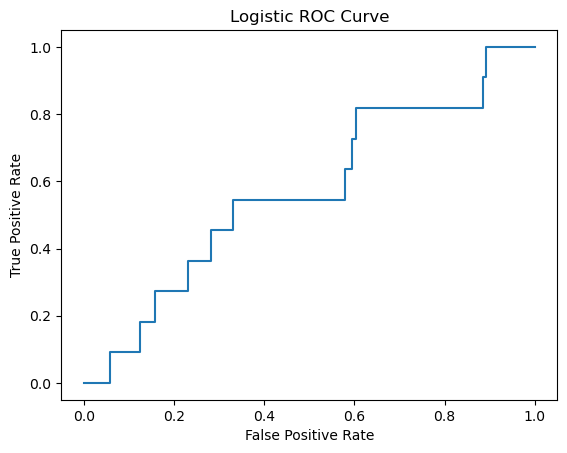

Logistic Accuracy: 0.9166666666666666
Logistic AUC score: 0.5694966190833959


In [214]:
# get predicted probabilities for test set
y_proba1 = model1.predict_proba(X_test)[:, 1]

# calculate false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba1)

# plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic ROC Curve')
plt.show()

# calculate AUC score
auc_score = roc_auc_score(y_test, y_proba1)
print('Logistic Accuracy:', accuracy1)
print('Logistic AUC score:', auc_score)

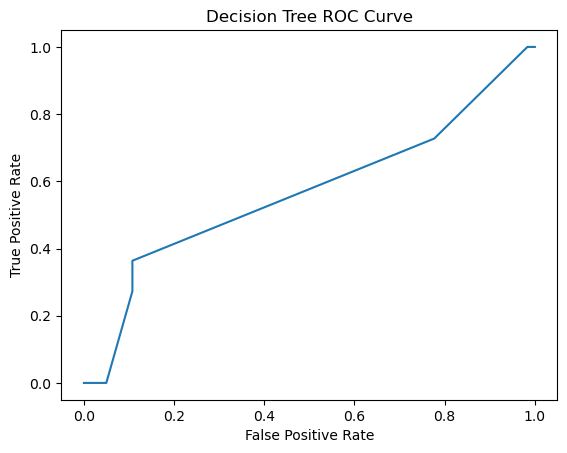

Decision Tree Accuracy: 0.8712121212121212
Decision Tree AUC score: 0.5679939894815929


In [215]:
# get predicted probabilities for test set
y_proba2 = model2.predict_proba(X_test)[:, 1]

# calculate false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba2)

# plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()

# calculate AUC score
auc_score = roc_auc_score(y_test, y_proba2)
print('Decision Tree Accuracy:', accuracy2)
print('Decision Tree AUC score:', auc_score)

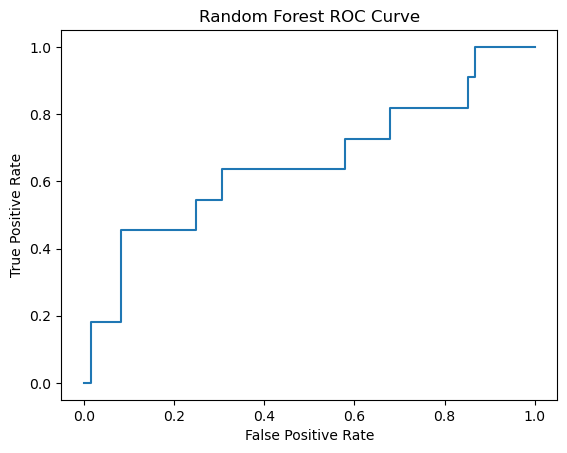

Random Forest Accuracy: 0.9166666666666666
Random Forest AUC score: 0.6536438767843726


In [216]:
# get predicted probabilities for test set
y_proba3 = model3.predict_proba(X_test)[:, 1]

# calculate false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba3)

# plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.show()

# calculate AUC score
auc_score = roc_auc_score(y_test, y_proba3)
print('Random Forest Accuracy:', accuracy3)
print('Random Forest AUC score:', auc_score)

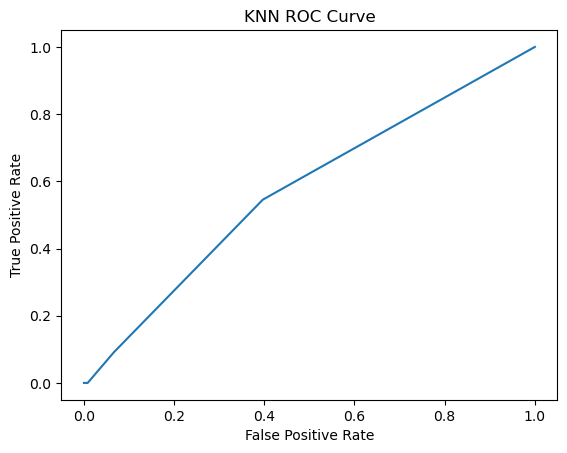

KNN Accuracy: 0.9090909090909091
KNN AUC score: 0.5740045078888054


In [217]:
# get predicted probabilities for test set
y_proba4 = model4.predict_proba(X_test)[:, 1]

# calculate false positive rate and true positive rate for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_proba4)

# plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.show()

# calculate AUC score
auc_score = roc_auc_score(y_test, y_proba4)
print('KNN Accuracy:', accuracy4)
print('KNN AUC score:', auc_score)

In [219]:
Region = FDI_df_20_2[["county","state"]]
FDI_20 = FDI_df_20_2[['Annual Average Establishment Count',
       'Annual Average Employment', 'Annual Total Wages', 'Annual Average Pay',
       '1000less', '1000to5000', '5000more', 'POPESTIMATE2020',
       'RDOMESTICMIG2020', 'RINTERNATIONALMIG2020', 'RNATURALINC2020']]

In [220]:
result = model3.predict(FDI_20)
FDI_20["FDI_20"] = result

/Users/jingyiwang/opt/anaconda3/envs/SSCI586/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- POPESTIMATE2020
- RDOMESTICMIG2020
- RINTERNATIONALMIG2020
- RNATURALINC2020
Feature names seen at fit time, yet now missing:
- POPESTIMATE2012
- RDOMESTICMIG2012
- RINTERNATIONALMIG2012
- RNATURALINC2012

  warnings.warn(message, FutureWarning)
/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/1741639692.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FDI_20["FDI_20"] = result


In [221]:
FDI_20["FDI_20"].describe()

count    2992.000000
mean        0.031417
std         0.174471
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: FDI_20, dtype: float64

In [222]:
FDI_Label_20 = pd.concat([Region, FDI_20], axis=1).reset_index(drop=True)

# Aggregate Shapefile

### FDI Label by County 

In [236]:
merged_data = county.merge(FDI_Labeled[["county","state","FDI"]], left_on=['NAME','STATE_NAME'], right_on=['county', 'state'], 
                           how='left')
merged_data.drop(["county","state"], axis=1, inplace=True)
merged_data["FDI"] = merged_data['FDI'].fillna(0)

merged_data = merged_data.merge(FDI_Label_20[["county","state","FDI_20"]], left_on=['NAME','STATE_NAME'], right_on=['county', 'state'], 
                           how='left')
merged_data.drop(["county","state"], axis=1, inplace=True)
merged_data["FDI_20"] = merged_data['FDI_20'].fillna(0)

In [241]:
merged_data.head(2)

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,geometry,FDI,FDI_20
0,Lake of the Woods County,Minnesota,27,077,27077,"POLYGON ((-95.34283 48.54668, -95.34105 48.715...",0.0,0.0
1,Ferry County,Washington,53,019,53019,"POLYGON ((-118.85163 47.94956, -118.84846 48.4...",0.0,0.0


In [240]:
merged_data.to_file('FDI_Counties/FDI_Counties.shp', driver='ESRI Shapefile')

### FDI State Data by Industry

In [272]:
state = gpd.read_file("USStates/USA_States_Generalized.shp")
FDI_Employee_12 = pd.read_csv("FDI/FDI_Industry_12.csv")
FDI_Employee_20 = pd.read_csv("FDI/FDI_Industry_20.csv")
FDI_employee_change = pd.read_csv("FDI/FDI_Industry_Change.csv")

In [268]:
state.head(2)

,FID,STATE_NAME,STATE_FIPS,SUB_REGION,STATE_ABBR,POPULATION,POP_SQMI,POP2010,POP10_SQMI,WHITE,...,RENTER_OCC,NO_FARMS12,AVE_SIZE12,CROP_ACR12,AVE_SALE12,SQMI,GlobalID,SHAPE_Leng,SHAPE_Area,geometry
0,1,Alaska,02,Pacific,AK,744733,1.3,710231,1.2,473576,...,95293,762.0,1094.0,84114.0,77329.0,581369.17,{CAA768F1-67C4-4E4E-BE1F-585897D5D651},407.570958,277.524097,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824..."
1,2,California,06,Pacific,CA,39611295,250.5,37253956,235.6,21453934,...,5542127,77857.0,328.0,9591783.0,547510.0,158144.83,{1B72B84F-AB21-4F2C-ABF1-D6029E20E2B9},42.260157,41.533618,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823..."


In [269]:
FDI_Employee_12.head(2)

,State,All industries,Manufacturing,Wholesale,Information,Finance,Professional
0,Connecticut,102.9,32.9,27.9,2.9,13.8,4.0
1,Maine,33.9,9.5,16.2,1.4,3.7,0.6


In [273]:
merged_data_12 = state.merge(FDI_Employee_12, left_on=['STATE_NAME'], right_on=['State'], 
                           how='left')
merged_data_12.drop(["State"], axis=1, inplace=True)

merged_data_20 = state.merge(FDI_Employee_20, left_on=['STATE_NAME'], right_on=['State'], 
                           how='left')
merged_data_20.drop(["State"], axis=1, inplace=True)

merged_data_change = state.merge(FDI_employee_change, left_on=['STATE_NAME'], right_on=['State'], 
                           how='left')
merged_data_change.drop(["State"], axis=1, inplace=True)

In [275]:
merged_data_12.to_file('FDI_States/Industry_12/FDI_Industry_12.shp', driver='ESRI Shapefile')
merged_data_20.to_file('FDI_States/Industry_20/FDI_Industry_20.shp', driver='ESRI Shapefile')
merged_data_change.to_file('FDI_States/Industry_change/FDI_Industry_change.shp', driver='ESRI Shapefile')

/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/3938783198.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_data_12.to_file('FDI_States/Industry_12/FDI_Industry_12.shp', driver='ESRI Shapefile')
/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/3938783198.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_data_20.to_file('FDI_States/Industry_20/FDI_Industry_20.shp', driver='ESRI Shapefile')
/var/folders/14/jyndvv096sqbkr5m6qz77nl40000gn/T/ipykernel_22529/3938783198.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  merged_data_change.to_file('FDI_States/Industry_change/FDI_Industry_change.shp', driver='ESRI Shapefile')


### Timeline Chart

In [293]:
time_df = pd.read_csv("FDI/FDI_Change_Year.csv")

In [309]:
# Melt the dataframe to "long" format
df_long = time_df.melt(id_vars=['Year'], var_name='Industry', value_name='Value')

# Create a line plot using plotly express
fig = px.line(df_long, x='Year', y='Value', color='Industry',
              title='Number of Employees Change (in thous.) by FDI Establishments',
              labels={'Year': 'Year', 'Value': 'Value', 'Industry': 'Industry'})

# Customize the layout
fig.update_layout(
    legend=dict(
        orientation='v',
        yanchor='middle',
        y=0.5,
        xanchor='right',
        x=1.3
    ),
    xaxis_tickfont_size=12,
    yaxis_tickfont_size=12,
    title_font_size=20,
    title_x=0.5,
    margin=dict(l=50, r=50, t=80, b=50)
)

# Show the plot
fig.show()